In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
gpp_data = xr.open_dataset("./gpp_Lmon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc")["gpp"]
cveg_data = xr.open_dataset("./cVeg_Lmon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc")["cVeg"]
ts_data = xr.open_dataset("./ts_Amon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc")["ts"]
hurs_data = xr.open_dataset("./hurs_Amon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc")["hurs"]
pr_data = xr.open_dataset("./pr_Amon_CanESM5_1pctCO2-rad_r1i1p1f1_gn_185001-200012.nc")["pr"]

In [24]:
def list_experiments(variableName="cVeg"):
    exps = set()
    for filename in os.listdir():
        if filename.startswith(variableName):
            #print(filename)
            exps.add(filename.split("_")[2])
    return exps


def load(variableName="cVeg", experiment="CanESM5"):
    experimentfiles = []
    for filename in os.listdir():
        if filename.startswith(variableName) and filename.split("_")[2].lower() == experiment.lower():
            experimentfiles.append(filename)
    
    experimentfiles.sort()
    nplist = []
    
    for filename in experimentfiles:
        arr = xr.open_dataset(filename)[variableName].to_numpy()
        nplist.append(arr)

    final = np.concatenate(nplist)    
    return final    

In [66]:
start_x = 12*(0) # 1850
end_x = 12*(25) # 1875
start_y = 12*(75) # 1925
end_y = 12*(100) # 1950

def avg20(ds):
    return np.mean(ds, axis=0) # axis of mean = time

In [28]:
from sklearn.linear_model import LinearRegression

In [71]:
def plot_and_test(input, output, mask,color=None,ax=plt):
    output = output[mask].flatten()
    input = input[mask].flatten()
    
    ax.scatter(input, output, alpha=0.2, color=color)

def fit_and_test(inputs, output, mask, test_inputs, test_output, title=""):
    inputs_c = inputs.copy()
    output_c = output.copy()

    test_inputs_c = test_inputs.copy()
    test_output_c = test_output.copy()
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(title)    
    axs[0][0].imshow(output[::-1], vmin=0, vmax=16)
    axs[0][1].imshow(test_output[::-1], vmin=0, vmax=16)  

    axs[0][0].set_ylabel("CMIP")
    axs[1][0].set_ylabel("Predicted")

    axs[0][0].set_title("Historical")
    axs[0][1].set_title("Future")

    modelshape = output.shape
    
    output = output[mask].flatten()
    test_output = test_output[mask].flatten()

    output_c = output_c.flatten()
    test_output_c = test_output_c.flatten()
    
    for i in range(len(inputs)):
        inputs[i] = inputs[i][mask].flatten()
        test_inputs[i] = test_inputs[i][mask].flatten()
        inputs_c[i] = inputs_c[i].flatten()
        test_inputs_c[i] = test_inputs_c[i].flatten()
    inputs = np.array(inputs).transpose()
    test_inputs = np.array(test_inputs).transpose()

    inputs_c = np.array(inputs_c).transpose()
    test_inputs_c = np.array(test_inputs_c).transpose()
    
    model = LinearRegression()
    model.fit(inputs, output)

    R2_present = model.score(inputs, output)
    R2_future = model.score(test_inputs, test_output)

    predicted_present = model.predict(inputs_c).reshape(modelshape)
    predicted_future = model.predict(test_inputs_c).reshape(modelshape)

    predicted_present[~mask] = 0
    predicted_future[~mask] = 0

    axs[1][0].imshow(predicted_present[::-1], vmin=0, vmax=16)
    axs[1][1].imshow(predicted_future[::-1], vmin=0, vmax=16)

    plt.savefig(title+'.png')
    
    print(title, "*", model.coef_, "+", model.intercept_)
    print(title, "R^2 Present", R2_present)
    print(title, "R^2 Future", R2_future) 
    
    return model

In [67]:
mask.shape

(64, 128)

NameError: name 'x_gpp' is not defined

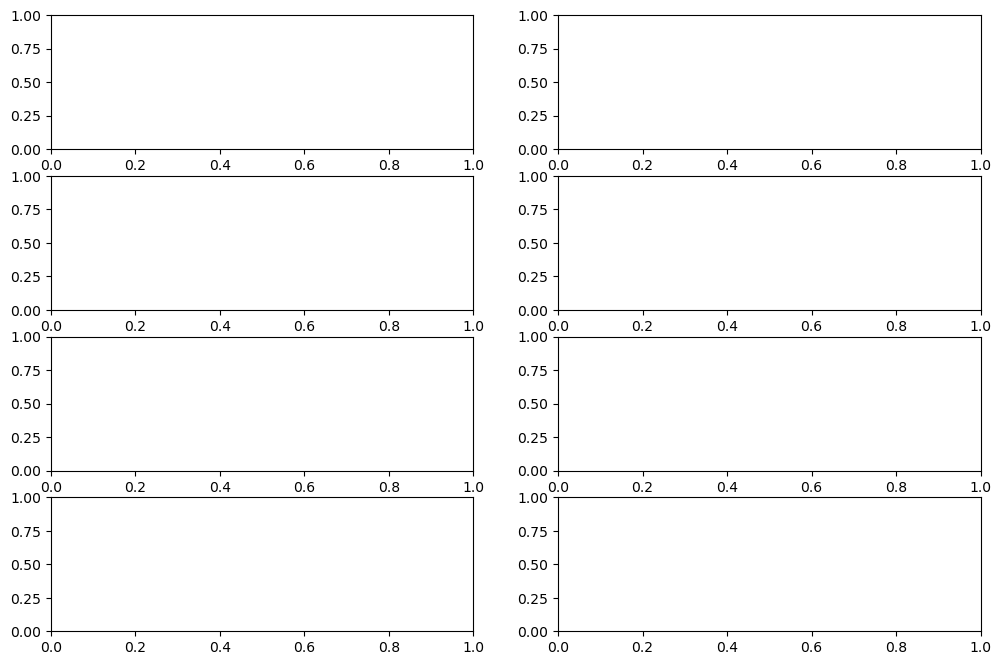

In [67]:
fig, axs = plt.subplots(4, 2, figsize=(12, 8))

fig_d = [
    [x_ts,x_pr,delta_ts,delta_pr],
    [x_ts*x_gpp,x_pr*x_gpp,delta_ts*x_gpp,delta_pr*x_gpp]
]

fig_c = [None, "g"]

for x in (0,1):
    for y in (0,1,2,3):
        plot_and_test(fig_d[x][y], delta_cveg, mask,ax=axs[y][x], color=fig_c[x])
axs[0][0].set_title("Unadjusted")
axs[0][1].set_title("Adjusted for gpp")
axs[0][0].set_ylabel("Start Temp.")
axs[1][0].set_ylabel("Start Precip.")
axs[2][0].set_ylabel("Delta Temp.")
axs[3][0].set_ylabel("Delta Precip.")

In [36]:
# Choose r to make sphere surface area 1 for easy multiplication later
# r = sqrt(1/4pi)
r = np.sqrt(1/(4*np.pi))

# Gets height of section of sphere given two angles
def getH(angles):
    angle_min = np.min(angles)
    angle_max = np.max(angles)
    
    # Hypotenuse = r
    # Hypotenuse * sin(Theta) = Opposite
    h_min = r * np.sin(angle_min)
    h_max = r * np.sin(angle_max)
    return h_max - h_min

# https://en.wikipedia.org/wiki/Spherical_segment
def getArea(horizontal_angles,vertical_angles,in_degrees=True):
    if in_degrees: # We need radians
        horizontal_angles *= (np.pi / 180)
        vertical_angles *= (np.pi / 180)

    left_bound = np.min(horizontal_angles)
    right_bound = np.max(horizontal_angles)
    arc_horz = right_bound - left_bound

    # 2 * pi * r * h * arc2
    return 2 * np.pi * r * getH(vertical_angles) * (arc_horz/(2*np.pi))

# should theoretically equal 1
print(getArea(np.array([-180,180], dtype=np.float64),np.array([90,-90], dtype=np.float64)))

def cuts(amount_vertical,amount_horizontal,vstart=90):
    space = np.linspace(-vstart,vstart,amount_vertical+1)
    width = 360/amount_horizontal
    y = []
    # We only care about vertical dimension
    for i in range(amount_vertical):
        y.append(getArea(np.array([0,width], dtype=np.float64), np.array([space[i],space[i+1]], dtype=np.float64)))
    x = np.array([y] * amount_horizontal)
    return x.transpose()

#cuts(10,5) # This may be in the wrong orientation but we can always transpose    

0.9999999999999999

In [32]:
def timeseries(values, name=""):
    i = 0
    weights = cuts(values.shape[1],values.shape[2])

    plt.figure(figsize=(12,4))
    
    values = np.nan_to_num(values)
    monthly = np.sum(values * weights, axis=(1,2))
    yearly = np.mean(monthly.reshape(-1, 12), axis=1)
    
    plt.plot(yearly)
    plt.title(name)

/usr/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.11/site-packages/xarray/coding/times.py:152: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warni

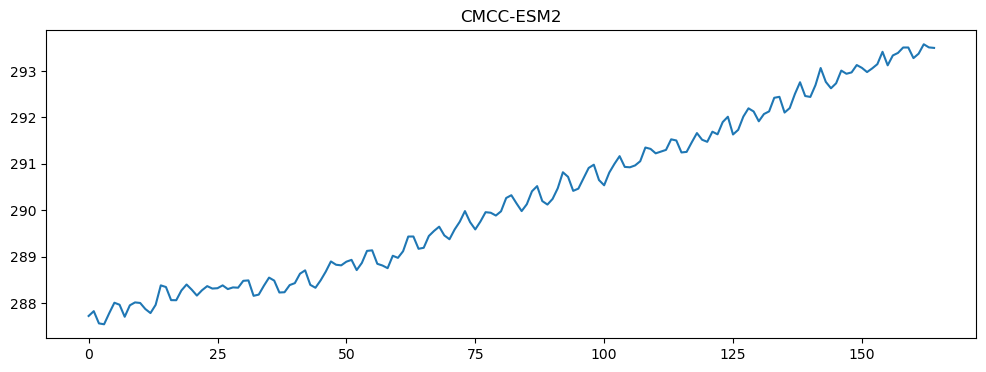

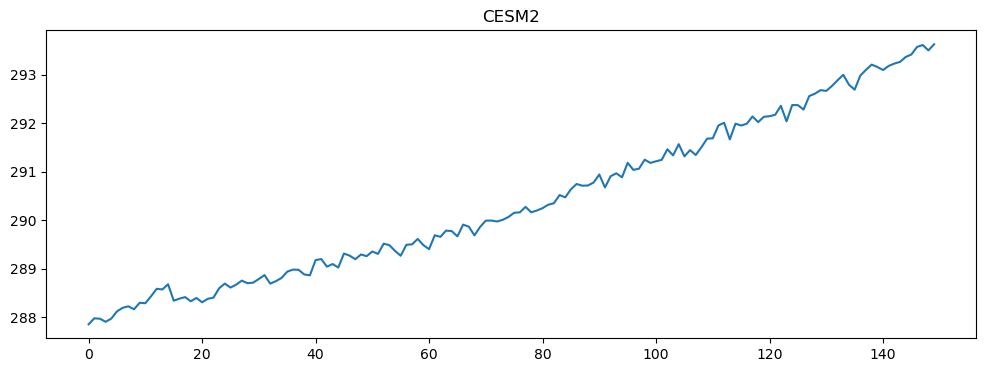

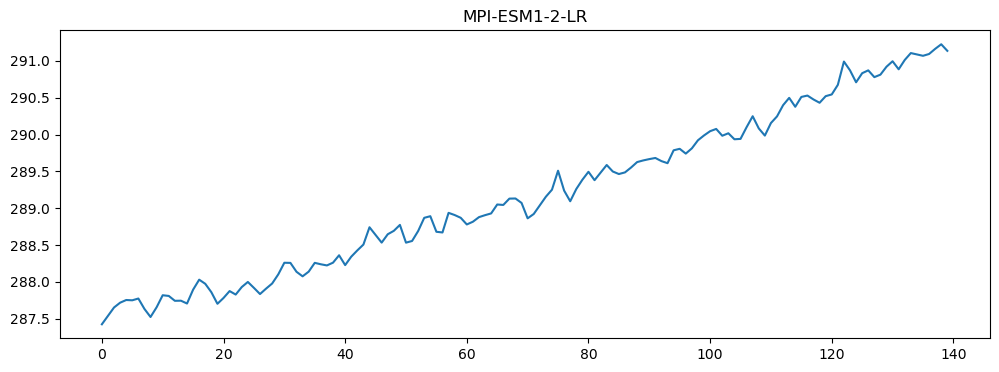

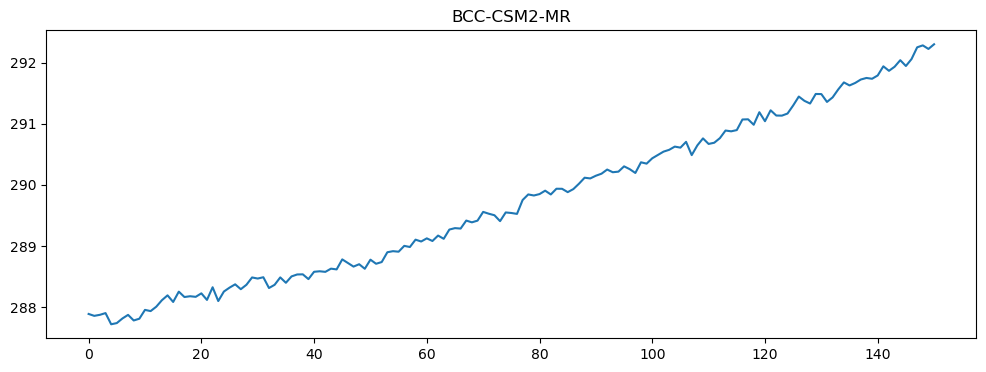

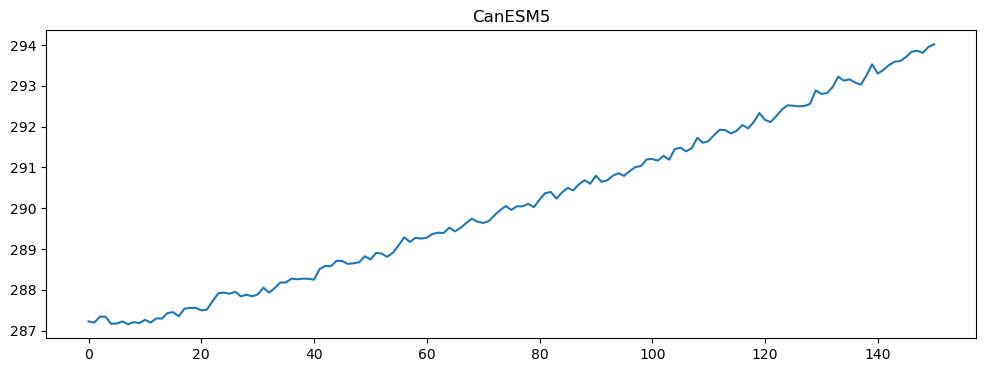

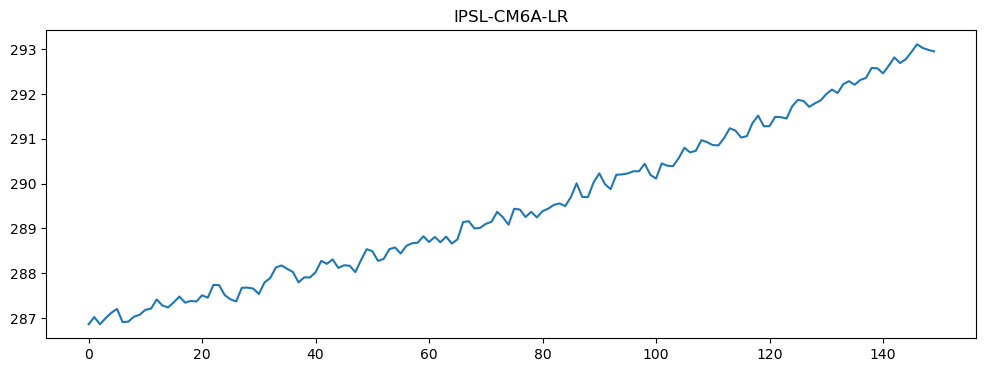

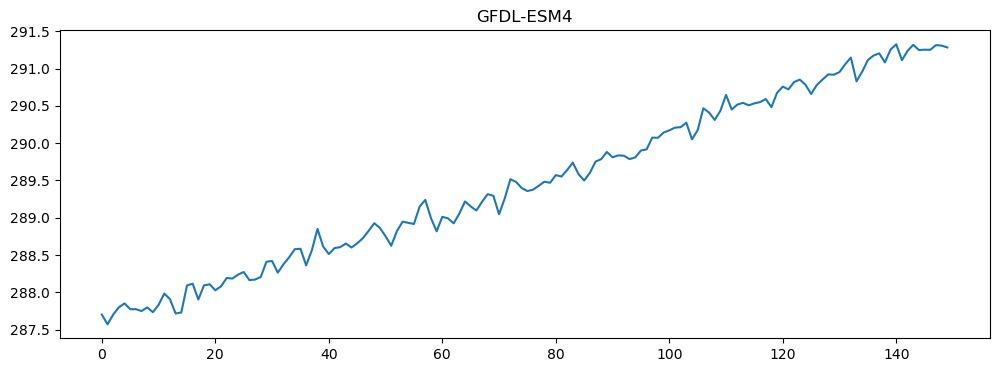

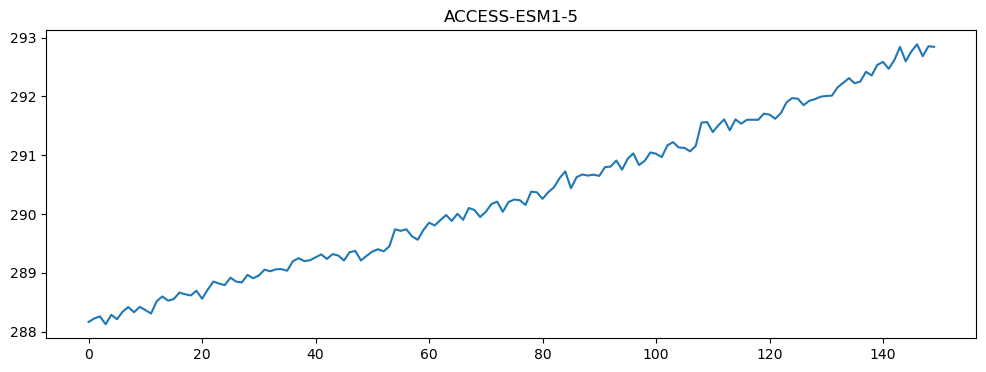

In [69]:
for expname in list_experiments("ts"):
    timeseries(load("ts", expname), expname)

CMCC-ESM2 * [-2.4594991e-02  1.5445251e+00  4.5285812e+02] + 6.2225113
CMCC-ESM2 R^2 Present 0.38816605145681815
CMCC-ESM2 R^2 Future 0.37929938203615576


/usr/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'cVeg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'cVeg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'cVeg' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/usr/lib/python3.11/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = deco

CESM2 * [-4.8746120e-02  1.9013672e+00  5.6118695e+02] + 13.599314
CESM2 R^2 Present 0.5261548068115949
CESM2 R^2 Future 0.4865752022862264
MPI-ESM1-2-LR * [4.2170495e-02 2.1813354e+00 6.3479230e+02] + -13.351904
MPI-ESM1-2-LR R^2 Present 0.6572347179622509
MPI-ESM1-2-LR R^2 Future 0.6565842231147186
BCC-CSM2-MR * [-2.3256782e-02  1.0456543e+00  3.0883307e+02] + 6.6910763
BCC-CSM2-MR R^2 Present 0.4169129700291082
BCC-CSM2-MR R^2 Future 0.3488930748938148
CanESM5 * [2.2041237e-02 1.2715149e+00 3.7565588e+02] + -5.3982325
CanESM5 R^2 Present 0.5635053402671327
CanESM5 R^2 Future 0.37726730533054154
IPSL-CM6A-LR * [6.5145031e-02 7.7870178e-01 2.2797581e+02] + -17.974796
IPSL-CM6A-LR R^2 Present 0.49872450995210516
IPSL-CM6A-LR R^2 Future 0.38359486067628823
GFDL-ESM4 * [-8.6833082e-02  1.4266052e+00  4.2048727e+02] + 24.477049
GFDL-ESM4 R^2 Present 0.37121275466911563
GFDL-ESM4 R^2 Future 0.34995367577899816


/usr/lib/python3.11/site-packages/xarray/coding/times.py:152: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/usr/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/lib/python3.11/site-packages/xarray/core/indexing.py:529: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/u

ACCESS-ESM1-5 * [-2.5824437e-02  1.4333496e+00  4.2448306e+02] + 7.707868
ACCESS-ESM1-5 R^2 Present 0.37412127270570494
ACCESS-ESM1-5 R^2 Future 0.29475564190996795


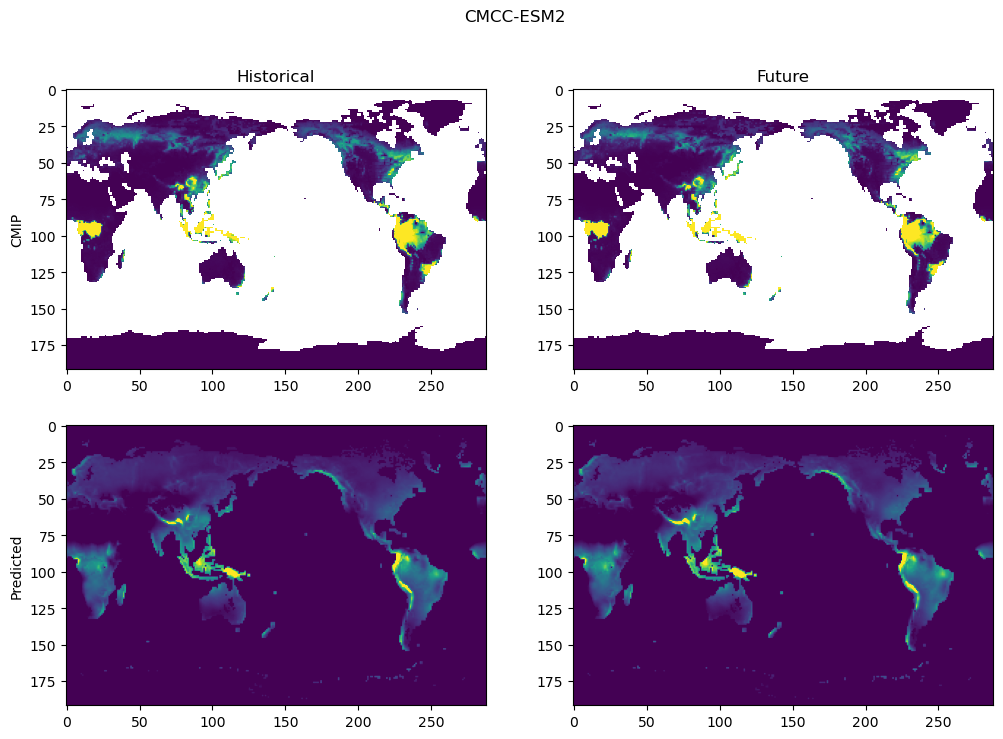

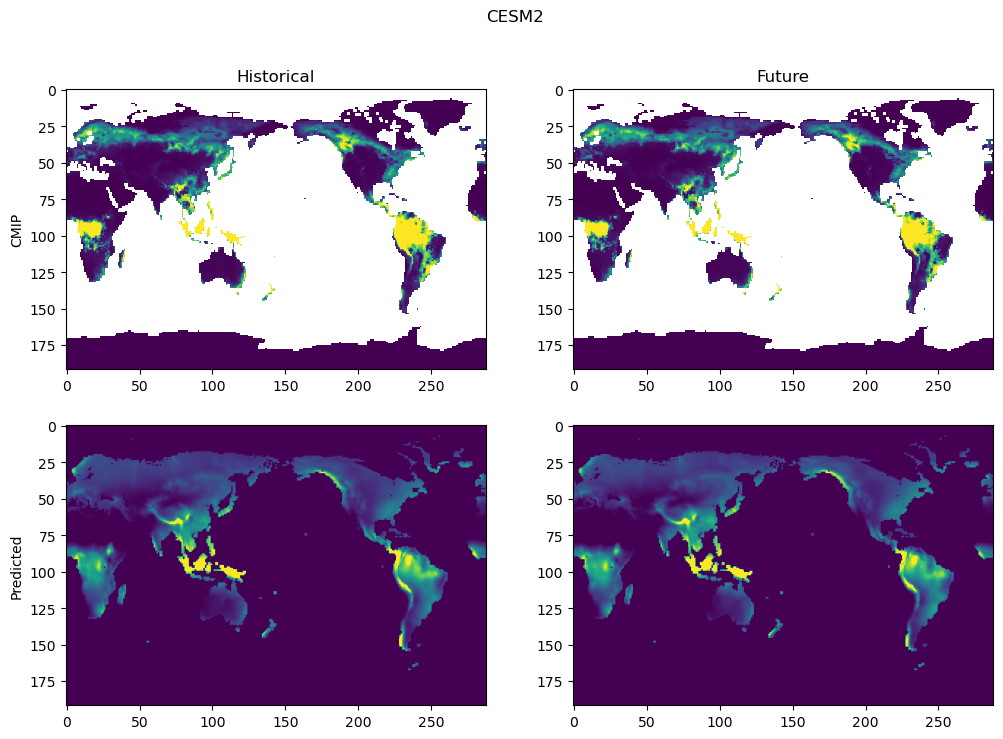

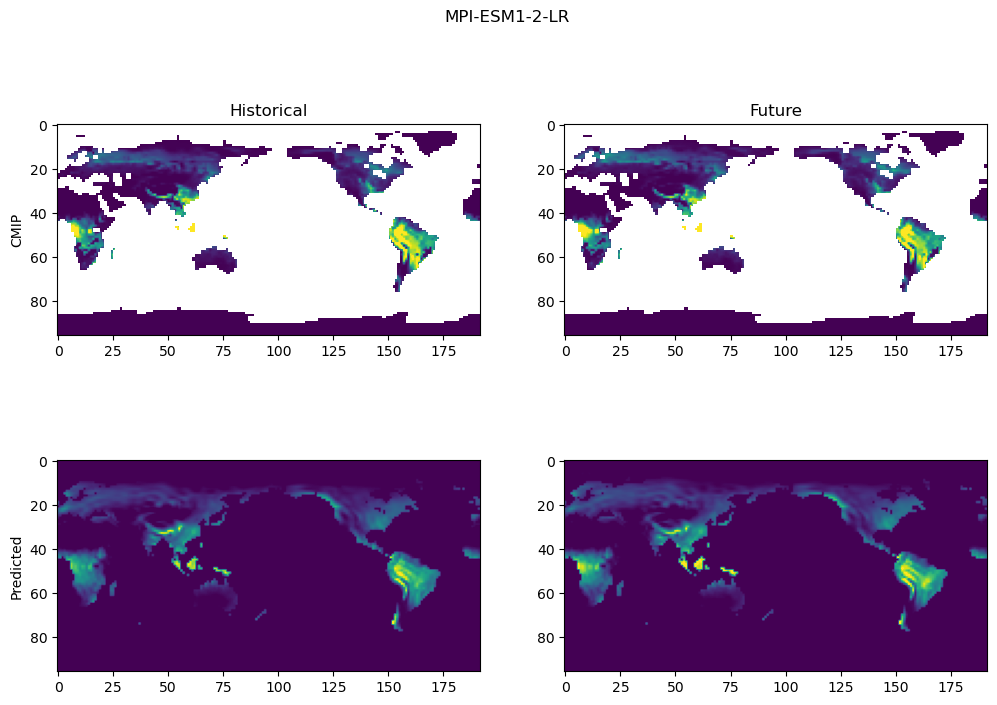

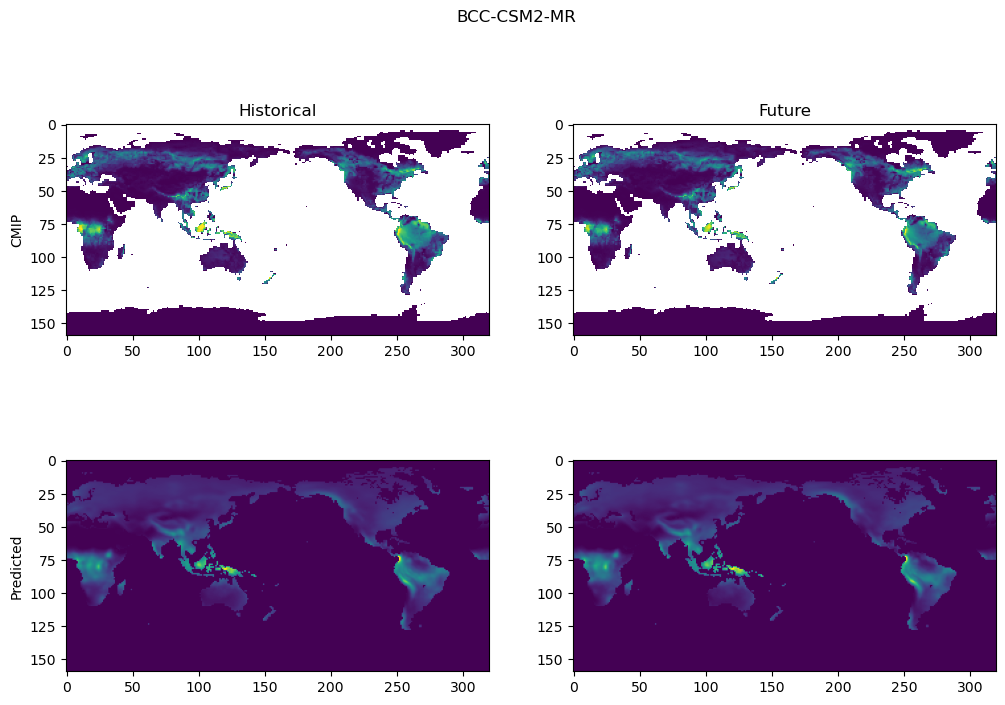

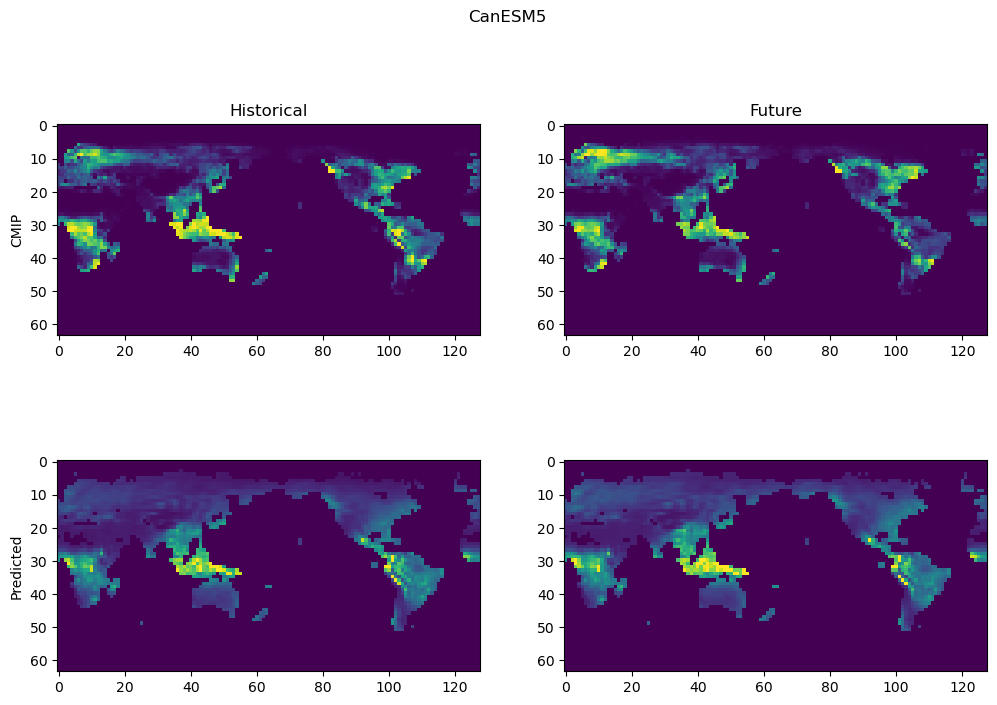

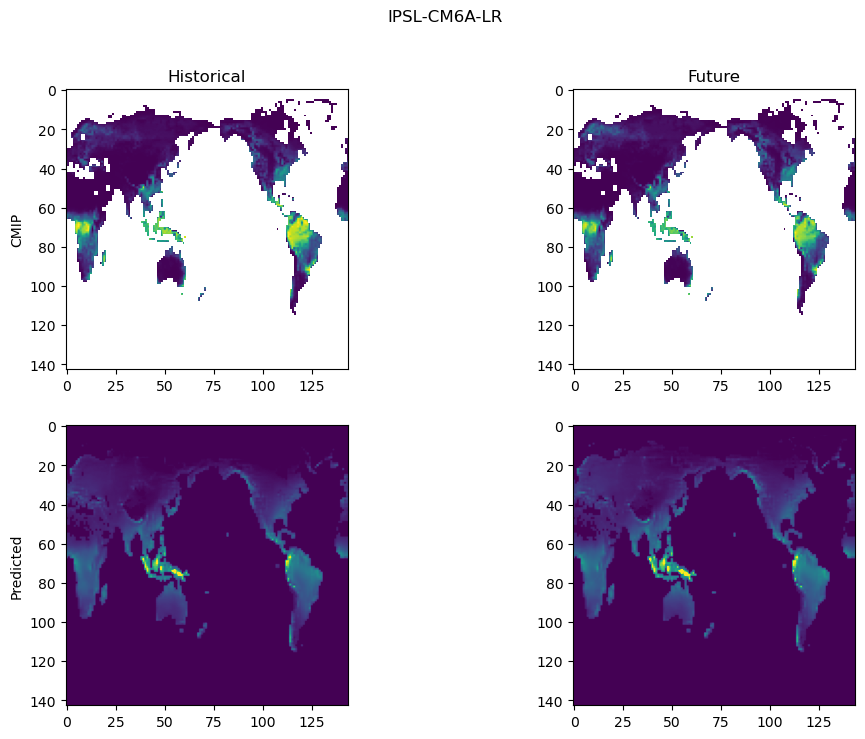

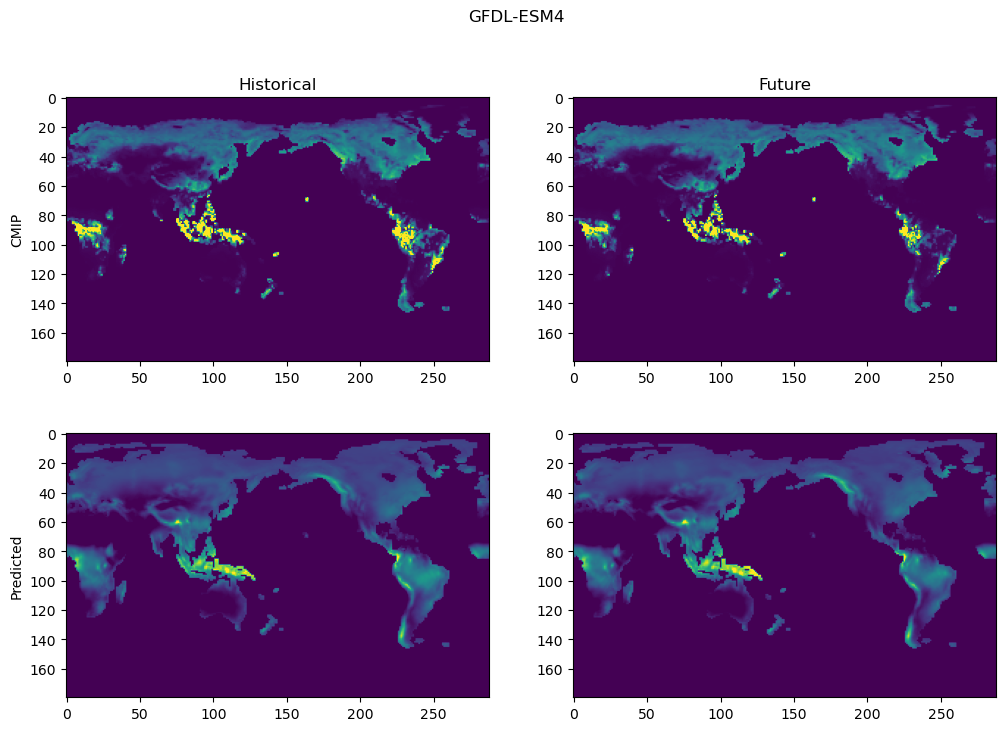

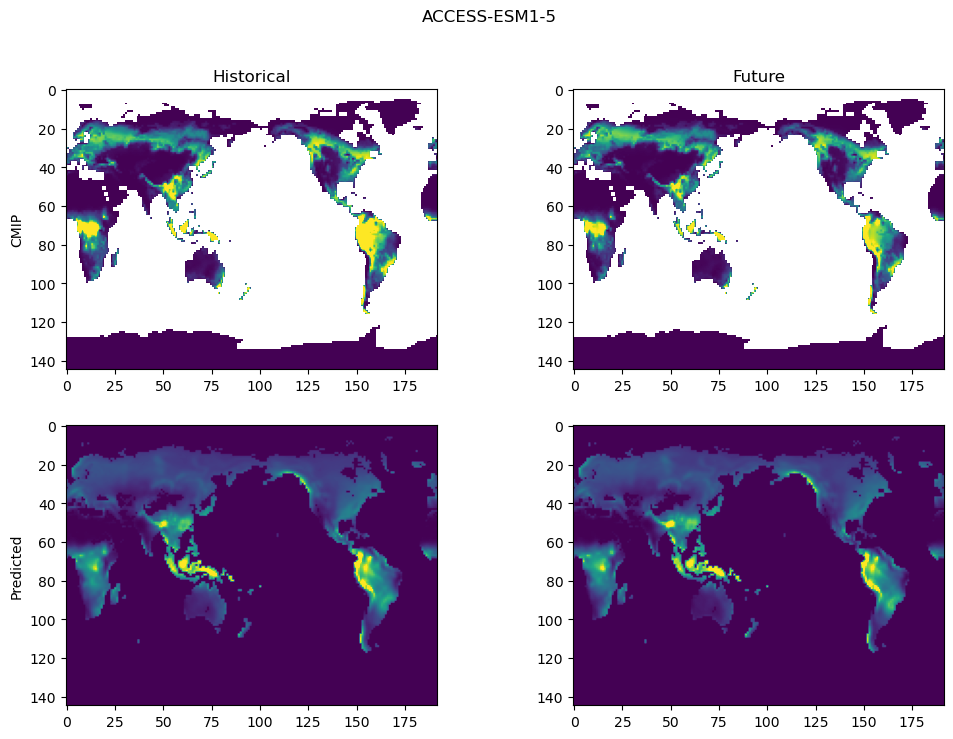

In [73]:
for expname in list_experiments("ts"):
    cveg_data = load("cVeg", expname)
    pr_data = load("pr", expname)
    ts_data = load("ts", expname)
    
    x_cveg = avg20(cveg_data[start_x:end_x,:,:])
    x_ts = avg20(ts_data[start_x:end_x,:,:])
    x_pr = avg20(pr_data[start_x:end_x,:,:])
    #x_gpp = avg20(gpp_data[start_x:end_x,:,:])
    y_ts = avg20(ts_data[start_y:end_y,:,:])
    y_pr = avg20(pr_data[start_y:end_y,:,:])
    #y_gpp = avg20(gpp_data[start_y:end_y,:,:])
    y_cveg = avg20(cveg_data[start_y:end_y,:,:])
    delta_ts = y_ts - x_ts
    delta_pr = y_pr - x_pr
    delta_cveg = y_cveg - x_cveg
    #delta_gpp = y_gpp - x_gpp
    
    mask = x_cveg > 0

    fit_and_test([x_ts, x_pr, x_ts*x_pr], x_cveg, mask, [y_ts, y_pr, y_ts*y_pr], y_cveg, expname)

In [59]:
for expname in list_experiments("ts"):
    print(expname)

CMCC-ESM2
CESM2
MPI-ESM1-2-LR
BCC-CSM2-MR
CanESM5
IPSL-CM6A-LR
GFDL-ESM4
ACCESS-ESM1-5
